In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import random
import copy

In [0]:
torch.set_printoptions(precision=10)

manualSeed = 1

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(manualSeed)

In [0]:
n = 2
coeff = [1,0,0]
orig_p = np.poly1d(coeff)

first, last = [-3, 2]


# Create Datapoints

In [0]:
npoints = 10
def create_data(npoints):
    xs = (last-first)*np.random.random_sample((npoints,)) + first
    ys = torch.tensor(orig_p(xs)).float().view(npoints,1)
    xs = torch.tensor(xs).float().view(npoints,1)
    return xs, ys

def create_data_cheb(d):
    cheb_n = np.zeros(d)
    for i in reversed(range(0,d)):
        cheb_n[i] = np.cos(np.pi*(i)/(d-1))
    cheb_n = (last-first)*(np.copy(cheb_n) + 1)/(1.*2) + first
    ys = torch.tensor(orig_p(cheb_n)).float()
    xs = torch.tensor(cheb_n).float().view(d,1)
    return xs, ys

xs, ys = create_data_cheb(npoints)

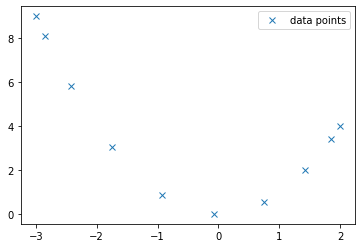

In [6]:
p_xs = xs.data.numpy()
p_ys = ys.data.numpy()
plt.plot(p_xs, p_ys, 'x', label='data points')
plt.legend()

# DNN approximating $x^2$ on $[a,b]$ interval

In [0]:
class Net_x2(nn.Module):
    def __init__(self, n, d, epsilon, a=0., b=1., w1=None, b1=None, p_k=None):
        super(Net_x2, self).__init__()
        self.n = n
        self.iter = int(np.log(1/epsilon))
        #self.lrelu = nn.LeakyReLU(0.1)
        print("number of h compositions %d" % self.iter)
        self.xrange = np.arange(first, last, 0.0005)
        self.a = a
        self.b = b
        self.c = (b-a)**2/4.
        
    def h(self, x):
        return 2*F.relu(x) - 4*F.relu(x-0.5) + 2*F.relu(x-1)

    def g1(self, x):
        return 2/(self.b-self.a)*F.relu(x-self.a) - 4/(self.b-self.a)*F.relu(x-(self.a+self.b)/2.) + 2/(self.b-self.a)*F.relu(x-self.b)
    
    def h_leaky(self, x):
        return 2*self.lrelu(x) - 4*self.lrelu(x-0.5) + 2*self.lrelu(x-1)
    
    def forward(self, x, plot=False):
        out = F.relu((self.a+self.b)*x - self.a*self.b)
        x = self.g1(x)
        
        if plot:
            test_x = torch.tensor(self.xrange).float().view(self.xrange.shape[0],1)
            plt.plot(self.xrange, test_x.data.numpy(), label='level 00')
            nn_ys = F.relu((self.a+self.b)*test_x - self.a*self.b).data.numpy()
            test_x = self.g1(test_x)
        
        for j in range(self.iter):
            
            out = out - self.c*x*(2.0**(-(j)*self.n))

            if plot:
                nn_ys = nn_ys - (self.c*test_x*(2.0**(-(j)*self.n))).data.numpy()
                plt.plot(self.xrange, (test_x*(2.0**(-(j)*self.n))).data.numpy(), ':', label='level %d'%j)
                plt.plot(self.xrange, nn_ys, label='out %d'%j)
                test_x = self.h(test_x)
            x = self.h(x)
                

        return out

In [8]:
eps = 0.00001
net = Net_x2(n, 1, eps, a=first, b=last)
#net = copy.deepcopy(net0)
criterion = nn.MSELoss()

net.eval()

number of h compositions 11


Net_x2()

# test accuracy

In [0]:
test_xs, test_ys = create_data(10000)

In [10]:
output = net(test_xs)
loss = criterion(output, test_ys)
print("loss ", loss.data)

loss  tensor(1.4609700168e-12)


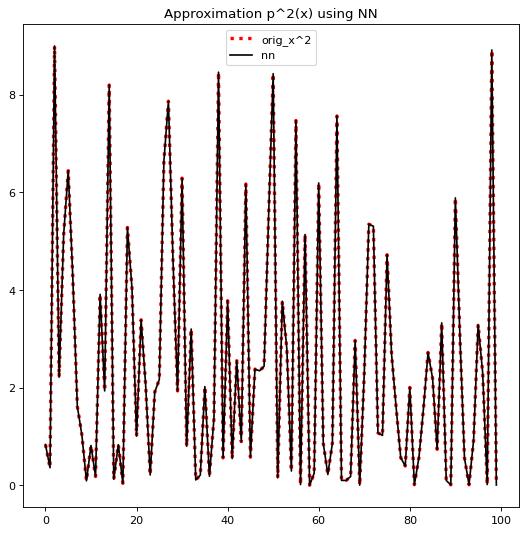

In [11]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')


def plot_p_nn(net):
    xs, xys = test_xs[:100], test_ys[:100]
    nn_ys = net(xs).data.numpy()
    axes.plot(xys.numpy().squeeze(), ':', label='orig_x^2', color='r', linewidth=3)
    axes.plot(nn_ys, color='k', label='nn')
    axes.legend()
    

plot_p_nn(net)
axes.set_title('Approximation p^%d(x) using NN'%n)


plt.show()

# plot NN approximation and original $p(x)=x^2$

In [12]:
xs = torch.tensor(np.array([0.2, 0.4, 0.8])).float().view(3,1)
nn_ys = net(xs).data.numpy()
print(nn_ys)

[[0.04000117]
 [0.16000086]
 [0.6400013 ]]


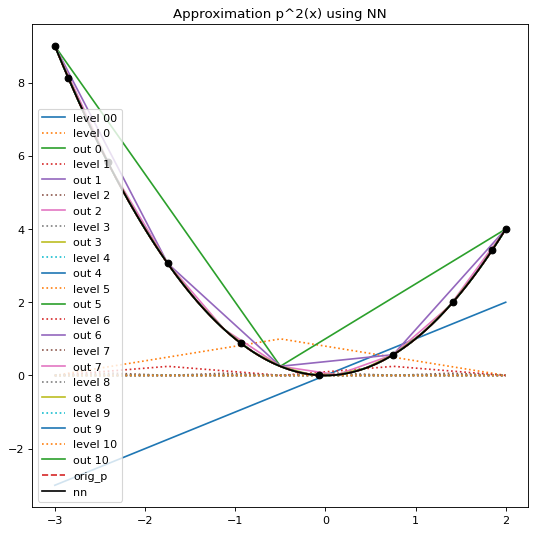

In [13]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')


def plot_p_nn(orig_p, net, n1):
    x = np.arange(first, last, 0.0001)
    xs = torch.tensor(x).float().view(x.shape[0],1)
    nn_ys = net(xs, plot=True).data.numpy()
    axes.plot(x, orig_p(x), '--', label='orig_p')
    axes.plot(x, nn_ys, color='k', label='nn')
    axes.legend()
    

plot_p_nn(orig_p, net, 0)
axes.plot(p_xs, p_ys, 'o', color='k', label='data points')
axes.set_title('Approximation p^%d(x) using NN'%n)


plt.show()

# error dependency on $\epsilon$



number of h compositions 0
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 1.0 loss  tensor(20.7621307373)
number of h compositions 2
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 0.1 loss  tensor(0.0812930241)
number of h compositions 4
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 0.010000000000000002 loss  tensor(0.0003173194)
number of h compositions 6
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 0.0010000000000000002 loss  tensor(1.2496008139e-06)
number of h compositions 9
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 0.00010000000000000002 loss  tensor(3.0570659892e-10)
number of h compositions 11
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 1.0000000000000003e-05 loss  tensor(1.4808728245e-12)
number of h compositions 13
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 1.0000000000000004e-06 loss  tensor(3.4710271766e-13)
number of h compositions 16
torch.Size([10000, 1]) torch.Size([10000, 1])
eps 1.0000000000000004e-07 loss  tensor(3.4586751323e-13)
n

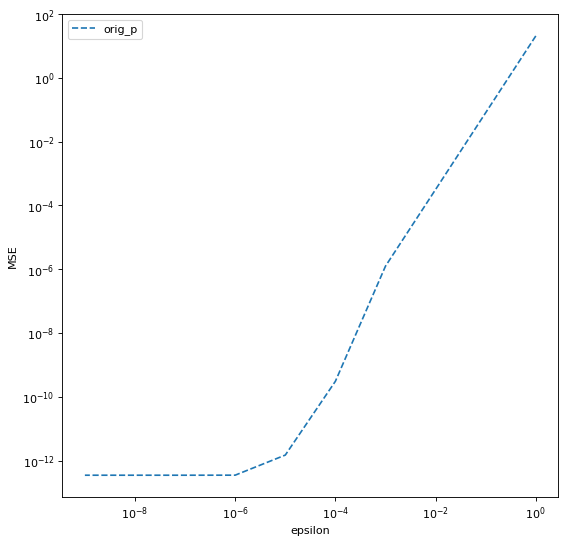

In [14]:
f, axes = plt.subplots(1,1, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
test_xs, test_ys = create_data(10000)
epsilons = [0.1**i for i in range(10)]
losses = []

for eps in epsilons:
    net = Net_x2(n, 1, eps, a=first, b=last)
    net.eval()
    output = net(test_xs)
    print(output.size(), test_ys.size())
    loss = criterion(output, test_ys).data
    print("eps", eps, "loss ", loss)
    losses += [loss]

axes.plot(epsilons, losses, '--', label='orig_p')
axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("epsilon")
axes.set_ylabel("MSE")
axes.legend()
